## Analysis of _Around the World in 80 days_
### Author: __Sam Lyddon__
***

This analysis uses entity recognition to extract the locations travelled to within the book _Around the World in 80 days_, and to compare them against the more general route locations obtained through manual extraction.

In [ ]:
import sys
sys.path.append("..")

In [2]:
from pathlib import Path
from collections import Counter
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

from src import RequestHandler, Document

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
%load_ext watermark
%watermark -d -t -u
%watermark -iv -v

last updated: 2020-02-28 10:12:19
CPython 3.7.6
IPython 7.12.0


In [5]:
%load_ext lab_black

### Pull in the text
***

In [6]:
rq = RequestHandler()

# scrape the text from a web source
# save to local file
data_path = Path("./../data/pg103.txt")
book_path = "http://www.gutenberg.org/cache/epub/103/pg103.txt"
if not data_path.is_file():
    text = rq.scrape_text(book_path)
    data_path.write_text(text.encode("utf-8"))
else:
    text = data_path.read_text()

#### Read document
***

Parse the document into chapters and paragraphs. Extract metadata.

In [7]:
%%time
doc = Document(text)
print(
    f"{doc.title} - {doc.author} - {doc.release_date} - {doc.last_updated} - {doc.language}"
)

Around the World in 80 Days - Jules Verne - May 15, 2008 [EBook #103] - May 5, 2012 - English
CPU times: user 9.33 s, sys: 73 ms, total: 9.4 s
Wall time: 9.43 s


In [8]:
print(f"{len(doc.chapters)} chapters, {len(doc.paragraphs)} paragraphs")

37 chapters, 1605 paragraphs


In [9]:
top_n = 5
print(
    f"{top_n} most mentioned characters: {[name for name, count in sorted(Counter([person for p in doc.paragraphs for person in p.people]).items(), key = lambda x: x[1], reverse=True)][:top_n]}"
)

5 most mentioned characters: ['Passepartout', 'Mr. Fogg', 'Fix', 'Phileas Fogg', 'Aouda']


#### Extract locations
***
Perform entity recognition on paragraphs to extract locations. Include whether the protagonist "Fogg" has been mentioned in the paragraph. Send location to OpenStreetMap to get coordinates.

In [10]:
locations = [
    (loc, para.mentions_fogg) for para in doc.paragraphs for loc in para.locations
]

In [11]:
locations = doc.get_locations()

### Plot route
***

Markers are scaled according to the number of occurances of the location.

Colour according to whether Fogg has been mentioned in the paragraph.

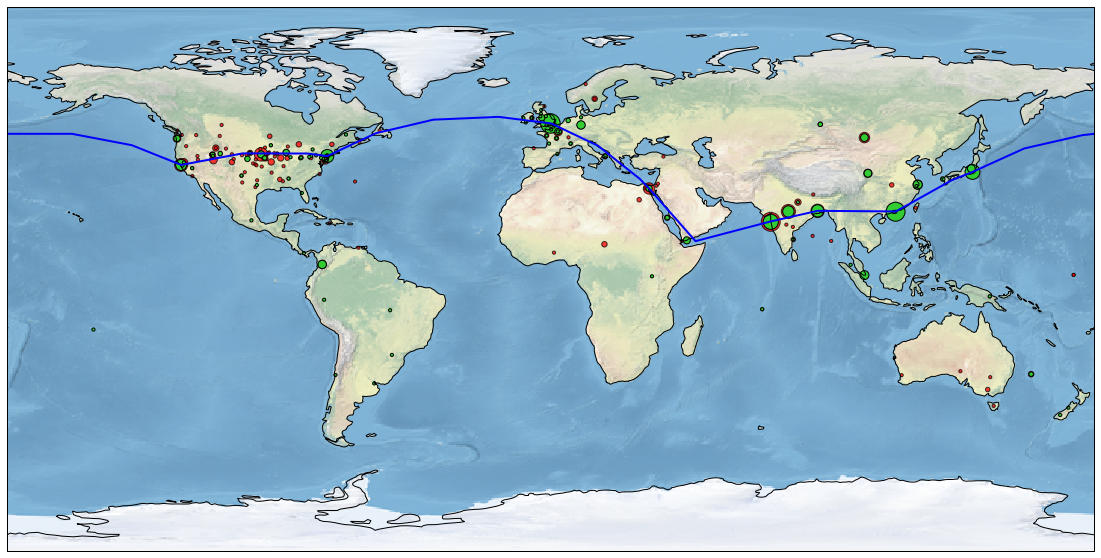

In [12]:
fig = plt.figure(figsize=(20, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.stock_img()

# manually retrieved route
lat = [
    51.5074,
    29.9668,
    12.5331,
    19.0760,
    22.5726,
    22.3193,
    35.4437,
    37.7749,
    40.7128,
    51.5074,
]
lon = [
    0.1278,
    32.5498,
    47.9224,
    72.8777,
    88.3639,
    114.1694,
    139.6380,
    -122.4194,
    -74.0060,
    0.1278,
]

ax.scatter(
    [loc["lon"] for loc in locations if not loc["has_fogg"]],
    [loc["lat"] for loc in locations if not loc["has_fogg"]],
    s=[loc["count"] * 10 for loc in locations if not loc["has_fogg"]],
    marker="o",
    edgecolors="black",
    color="red",
    alpha=0.75,
    transform=ccrs.PlateCarree(),
)
ax.scatter(
    [loc["lon"] for loc in locations if loc["has_fogg"]],
    [loc["lat"] for loc in locations if loc["has_fogg"]],
    s=[loc["count"] * 10 for loc in locations if loc["has_fogg"]],
    marker="o",
    edgecolors="black",
    color="limegreen",
    transform=ccrs.PlateCarree(),
)
ax.plot(lon, lat, color="blue", linewidth=2, transform=ccrs.Geodetic())

ax.coastlines()
plt.xlim([-180, 180])
plt.ylim([-90, 90])
plt.show()

### TODO
***
Improve use of contextual information e.g. surrounding paragraphs to:

* attribute places to people
* attribute times to places


***